# Using Decision Trees for charting ill-behaved datasets

This post presents a technique that's served me well on a past project involving a lot of ill-behaved data: using **Decision Trees for data exploration,** and more specifically for **investigating pathological properties** in datasets, such as missing data attributes.

This can be especially useful for **maintaining complex databases,** obtained by aggregating many external sources. Decision Trees are an old and well-known technique, but I don't know that they're often considered for this use case. From what I've seen, Decision Trees are good at "reverse-engineering" the superposition of factors that result in incomplete data.

Let me know what you think! I'd love to know how other people approach this sort of problem. I might pull this out into Open-Source tooling someday, although making it generic enough could be challenging. In my experience, implementing this atop an existing database is one or two day's work.

**Table of Contents:**

* **[The problem](#The-problem)**
* **[User Experience](#User-Experience)**
* **[How it works: Information Gain and Decision Trees](#How-it-works:-Information-Gain-and-Decision-Trees)**
  - [Choosing a Split Criterion](#Choosing-a-Split-Criterion)
  - [Building the Decision Tree](#Building-the-Decision-Tree)
* **[Implementing against a database](#Implementing-against-a-database)**
* **[Non-trivial splits](#Non-trivial-splits)**
  - [Temporal features](#Temporal-features)
  - [High-cardinality categorical features](#High-cardinality-categorical-features)
  - [Multi-feature and Machine-Learned Split Criteria](#Multi-feature-and-Machine-Learned-Split-Criteria)
* **[On the shortcomings of Decision Trees](#On-the-shortcomings-of-Decision-Trees)**
* **[Appendix: deriving the Total Information Gain formula](#Appendix:-deriving-the-Total-Information-Gain-formula)**
  - [Information Theory refresher: Entropy and Mutual Information](#Information-Theory-refresher:-Entropy-and-Mutual-Information)
  - [From Mutual Information to Total Information Gain](#From-Mutual-Information-to-Total-Information-Gain)
  - [Why scale by $N(\nu)$ ?](#Why-scale-by-$N(\nu)$-?)
  - [Other purity metrics](#Other-purity-metrics)
* **[References](#References)**

## The problem

Suppose you're working on a software project, which consists of **leveraging data that you don't understand very well** (typically because the data comes from external and disparate sources). 

Here are some examples of such data, from my own experience: 

* Sales Records from many different e-commerce websites, to be processed for accounting purposes.
* Metadata about academic works from many publishers and journals (as you may find on [Unpaywall.org](https://unpaywall.org/)), to be indexed into a search engine.

We'll use this last example (academic works) as an illustration for this article.

So, picture yourself developing a search engine for academic content (exciting, isn't it?). One morning, your Product Manager colleague bursts into your office: 

_"- Hey, I just used the search engine and noticed some articles are **lacking a PDF link,** what's going on?"_

Your colleague just pointed out some **_pathological property_ of the data, which you must now investigate.** Here are a few readily available investigation strategies:

1. Make an **educated guess**, e.g: _"Oh, that must be because these articles are not Open Access"_. (As we'll see, in this case and many others, this would only be a partial explanation, and it would be a mistake to leave it at that.)
2. Run a script or database query to **inspect a sample of pathological documents**, you might notice something.
3. Run various database queries to collect **global statistics** about the pathological data, some correlations might hint you towards the cause(s) of the problem. For example, you might notice that the pathological property (missing PDF) is more present in some academic publishers than others, or after a specific date.

This article describes a technique for automating approach 3: an algorithm that will run many database queries for you, more thoroughly than your patience would allow for, and presenting you some interesting statistical correlations to guide your investigation.

## User Experience

You fill in the property "lacks a PDF link" in a script, which runs for a few seconds or minutes, then produces an output such as this:

![Decision Tree viz example](../img/decision-trees-pathological-data-example.png)

_(This is displayed as coloured terminal output, but you could imagine other media e.g a web browser UI.)_

This sort of visualization is rather dense, but with some training it becomes quite readable. It gives us a finer view of how the pathological property is distributed in our dataset, partitioning the data into regions where it's particularly present or rare. Here's how you would interpret it:

* The pathological property "lacks a PDF link" has been translated to an ElasticSearch query `{:bool {:must_not {:exists {:field :article_url_for_pdf}}}}`
* The entire database contains about 100 million documents (`n=1.0e+08`), 80.2% of which lack a PDF link (`p=8.02e-01`).
* The algorithm then chose to break down these 100 millions documents by Open Accessibility (`>> SPLIT BY :article_is_oa`): 25 million are Open-Access (`OA`, `n=2.5e+07`), 77 million are not (`not OA`, `n=7.7e+07`).
* The non-Open-Access  documents all lack a PDF (`p=1.0e+00`). That's our "educated guess" from above, and indeed explains most of the phenomenon. However, that's not the end of the story.
* Of the 25 million are Open Access documents, 19.7% lack a PDF link (`p=1.97e-01`).
* Of these, 4.5 million were published either by Elsevier BV or Public Library of Science (`∈ #{"Elsevier BV" "Public Library of Science (PLoS)"}`), with an unusually high rate of 78.2% of missing PDF links, whereas the 20 million articles not published by these 2 publishers average to `6.72%` missing PDF links. So you might say that `Elsevier BV` and `PLoS` are exceptionally bad at providing PDFs links for their Open-Access content, and you might want to reach out to them to fix the issue.
* The algorithm decomposes further the data by publishers, highlighting a few publishers that are either exceptionally good (`"American Physical Society (APS)"` etc.) or exceptionally bad (`"Medknow"`) at providing PDF links.
* We then see that chronology matters (`>> SPLIT BY [:article_year 2000]`): of 14 million documents, 3.2 million were published before 2000 with 2.45% of them lacking a PDF link, 10 million were published after 2000 with 10.3% of them lacking a PDF link, and 600,000 have no known publication date with 12.5% of them lacking a PDF link. What happened after 2000?

In summary, this visualization leads to us to "explain" the lack of PDF links by a **superposition of various factors:** predominantly the non-Open-Accessibility, but also differences in publisher data, and finally chronology. It's unlikely we would have spotted all of these trends through manual analysis, whereas obtaining this visualization required no more effort than writing a single database query.

The rest of the article will be devoted to the how these trees are produced, but I want to emphasize the following: **you don't need to understand the algorithm to benefit from it.** The point of the algorithm is to exhibit some interesting statistics, which are useful and understandable in and of themselves, and as a user you don't need to know how the algorithm came up with them.

## How it works: Information Gain and Decision Trees

The above vizualization relies on an established Machine Learning algorithm: **Decision Trees,** which I'll re-introduce in this section. Note that whereas the conventional use of Decision Trees is _prediction_ on future inputs, here we use it for _data visualization and exploration_ of existing data.

The idea of Decision Trees is rather simple: they **break down the data in the 'most informative way'** to help you investigate some property, thus splitting the data into several subsets, then **apply the same procedure to each split subset.**

### Choosing a Split Criterion

What does a 'most informative' breakdown consist of? To illustrate it, let's first do the work from intuition.

Suppose I give you a breakdown of the articles by both geographic area and publication era (numbers are deliberately made up and inconsistent with the previous section):


**Total articles:** 108.2 million, 33.8 million of them lacking a PDF link (31.2%).

**By Geographic Area:**

| Geographic Area ($s$) | # articles ($N_s$) | lacking PDF link ($N_s^+$)|
| ----------------|------------|--------------------|
| Asia            | 45.7 million | 14.9 million (32.7%)|
| Europe & Africa | 26.9 million | 8.18 million (30.4%)|
| Americas        | 35.6 million | 10.6 million (29.8%)|

**By Publication Era:**

| Publication Era ($s$) | # articles ($N_s$) | lacking PDF link ($N_s^+$)|
| ----------------|------------|--------------------|
| 1900-1999       | 42.2 million | 5.53 million (13.1%)|
| 2000-2020       | 66.0 million | 28.1 million (42.7%)|

Which of these two tables help you the most investigate the lack of PDF links ? If that's not clear, maybe a picture will help:

![MI-geographic-temporal-breakdown-mosaic-plot](../img/MI-geographic-temporal-breakdown-mosaic-plot.svg)

In this case, I think it's intuitively obvious that _Publication Era_ helps us more than _Geographic Area,_ as the former heavily influences the proportion of lacking PDFs. The essence of our algorithm is that it will automatically choose two show you the most helpful of both charts (and then dig deeper).

Now all we need is a bit of "Artificial Intelligence" to translate this intuition to a computation. One insight behind Decision Trees is to use notions from the field of Information Theory to do that.

Concretely, we choose the split criterion $S$ (such as 'Publication Era' or 'Geographic Area') that yields the highest **Total Information Gain** $G[S]$, a quantity measured in bits.datapoint, and computed as:

$$ G[S] :=  N . H_2\left(\frac{N^+}{N}\right) - \sum_s{N_s . H_2\left(\frac{N_s^+}{N_s}\right)} $$

... in which:

* $H_2$ is the **[binary entropy function](https://en.wikipedia.org/wiki/Binary_entropy_function):** $H_2(p) := - p \log_2(p) - (1-p) \log_2(1-p)$. _(Note: this function never takes negative values, and so the first term in the formula is an upper bound for $G[S]$.)_
* $N$ is the total number of articles considered,
* $N^+$ is the number of articles having the pathological property,
* $N_s$ is the number of articles for which the split criterion $S$ takes the value $s$,
* $N_s^+$ is the number of articles having the pathological property _and_ for which $S$ takes the value $s$.

A theoretical justification for this formula can be found in the [appendix](#Appendix:-deriving-the-Total-Information-Gain-formula). Sorry if the notation is a bit intimidating to some readers - what's important for practical problem-solving is not understanding the math, but being able to program it.

In our example, we have:

* $N = 108.2 \text{ million}$
* $N^+ = 33.8 \text{ million}$
* for $S = \text{"Geographic Area"}$ and $s = \text{"Asia"}$, $N_s^+ = 14.9 \text{ million}$ and $N_s = 47.5 \text{ million}$.
* $G[\text{"Geographic Area"}] = 6.00 \times 10^4 \text{ bits.datapoint}$ 
* $G[\text{"Publication Era"}] = 8.15 \times 10^6 \text{ bits.datapoint}$, and so this split criterion is indeed preferred.


Note in particular that the $N_s$ and $N_s^+$ can be directly read from the frequency tables above; also $N^+ = \left( \sum_s N_s^+ \right)$, and $N = \left( \sum_s N_s \right)$. So in order to compute $G[S]$, **all the data querying we have to do consists of computing the frequency table** for $S$, which we can then feed into the above formula.

#### On the meaning of 'Information Gain'

At this point, you may want to call something out: 

_"Are you really telling us that there is a mathematical formula for predicting how informative some piece of data is? This seems too good to be true."_

Indeed, although we're talking about "Information Gain", you should treat this phrase as technical jargon from the field of Information Theory, not as some magical quantity that captures the essence of what you and I would call "useful information" (we don't have a general-purpose formula for that). If I told you whether each gas molecule in your living room is moving upwards or downwards, I would technically be giving you gadzillions of megabazillions of bits of 'information' about the state of the universe, but that information would still be completely worthless to you, even if that's more bits of reduced entropy than you would get from reading Wikipedia or even my blog in their entirety.

Rather, the Information Gain expressed by the above formula is merely a heuristic, a naive proxy for how insightful some perspective on our data is - but at least this heuristic is computable. You may find it disappointing, but that is as good as it gets with Machine Learning.

### Building the Decision Tree

Once we have computed the best Split Criterion, we can use it to split the dataset into several subsets, creating the first children nodes in our tree. Then we can apply the same procedure to each child node... thus growing our tree from the top. 

Here are some **practical considerations:**

* Unless your number of Split Criteria is very small, you will want to put a **stopping condition** to that process, such as the number of nodes or depth of the tree. Otherwise your tree will grow very large, making it unreadable and slow to compute.
* **Not all nodes are interesting to expand.** For nodes that contain very few datapoints, or achieve extreme purity (i.e the pathological property is either very frequent or very rare), there will be hardly any information to be gained. In particular, when total purity is achieved (when either all nodes or none of them have the pathological property), then there is no more information to be gained.
* Having expanded a node with a particular Split Criterion, there's no point in considering it again for its children, as that wouldn't split the data at all. That said, as the Total Information Gain would necessarily be zero, that would not make the algorithm incorrect, only wasteful.

With that in mind, growing the tree can be viewed as a search algorithm: at each iteration, you're looking for an optimal leaf node and Split Criterion to expand it. The Total Information Gain can be compared across nodes, making it suitable to guide that search.

One option is to search exhaustively: always consider all leaf nodes, displaying only those that have contributed the highest information gain. If that's too slow, you might want to narrow your search with a heuristic. In both cases, you will want to have some priority ordering of leaf nodes: for instance, you might give precedence to the leaf nodes of highest residual entropy $N . H_2\left(\frac{N^+}{N}\right)$; you could also refine that expression to penalize nodes of high depth, e.g $K^d . N . H_2\left(\frac{N^+}{N}\right)$ where $d$ is the depth of the node and $K < 1$.

## Implementing against a database

As we've seen, to evaluate Split Criteria, you need to compute count aggregations at the leaf nodes of the tree. If the size of the dataset is small enough, you can implement the aggregations in-memory. Otherwise, you will probably want to do that by sending queries to a datastore such as ElasticSearch or a SQL database.

In a typical SQL implementation, the path to a leaf node will translate to a `WHERE` clause, each element of that path adding an `AND`; and the Split Criterion being evaluated will correspond to a `GROUP BY` clause.

For example, in our example tree from above, the `>> SPLIT BY :top_publishers` below `NODE<3>` (in blue) could be evaluated by the following query:

```sql
SELECT COUNT(*) AS N_s, SUM(one_if_pathological) AS N_s_pos FROM (
  SELECT article_id, article_publisher,(CASE WHEN article_url_for_pdf is NULL THEN 1 ELSE 0) AS one_if_pathological
  FROM articles
  WHERE article_is_oa
  AND NOT article_publisher IN ("Elsevier BV", "Public Library of Science (PLoS)") 
) AS t
GROUP BY article_publisher
```

Another strategy is to compute the aggregation for **several leaf nodes at the same time, using a conditional expression** that computes the 'id' of the leaf nodes. The advantage is to run one query for several leaf nodes; the downside is that you scan more data and might not leverage indexes optimally. For example, here's a query that would evaluate the 'publishers' Split Criterion for nodes `<02>`, `<04>` and `<05>` in one fell swoop:

```sql
SELECT node_id, COUNT(*) AS N_s, SUM(one_if_pathological) AS N_s_pos FROM (
  SELECT 
    article_id, 
    article_publisher,
    (CASE WHEN article_url_for_pdf is NULL THEN 1 ELSE 0) AS one_if_pathological,
    (CASE WHEN article_is_oa THEN
      (CASE WHEN article_publisher IN ("Elsevier BV", "Public Library of Science (PLoS)") THEN
        4
        ELSE (CASE WHEN article_publisher IN ("American Physical Society (AMS)", "American Society for Biochemistry & Molecular Biology (ASBMB)" ...) THEN 
          5
          ELSE -1))
     ELSE 2
    ) AS node_id
  FROM articles
  WHERE NOT node_id = -1
) AS t
GROUP BY article_publisher
```


I do not know of a satisfactory way to evaluate several Split Criteria in one query in SQL. This is something that's straightforward to do with ElasticSearch aggregations. In addition, ElasticSearch has the advantage of enabling you to trade accuracy for speed, making it well suited for such use cases.

## Non-trivial splits

In this section we examine some special cases of Split Criteria that demand special processing.

### Temporal features

When your data has a temporal feature, you can't directly break it down by that feature - for example, if the publication date is milli-second encoded, all articles may have a distinct publication date, and your dataset would be split into as many subsets as articles, which would make your Decision Tree unreadable.

One strategy is to bucket the data, for example by decade. Even that may leave too many subsets for good readability.

Therefore, one strategy to consider is to make a **binary temporal split:** split the data into "before" and "after" a specific "pivot" date. The question then becomes: how to find the most informative pivot date?

The strategy I recommend is to bucket the data into intervals (e.g decades or years, even finer depending on your needs), then search for the optimal pivot date amongst interval bounds, i.e the one that yields the highest Information Gain. By using cumulated counts, this sum can be done in linear time in the number of buckets.

Of course, this logic can be applied to any real-valued feature, not just dates.

### High-cardinality categorical features

Some categorical features, such as 'publisher' in our example, can take many values - hundreds or thousands. That's too many to make a useful split, as the Decision Tree would become unreadable (even though the Information Gain might be very high).

Again, one mitigation strategy is to make a **binary split:** split the data points as belonging or not belonging to a small subset of the categorical values. The question becomes one of choosing that subset. Here's one approach to it:

* Bucket the datapoints into a small number (say, 10) of "important" categorical values, for instance the ones that contain the most datapoints, as they're more likely to contribute to entropy reduction. Collapse the other values into an `"OTHER"`value.
* Search for an optimal subset of these values to split the data by. This can be done efficiently by sorting the buckets into a list ordered by purity (the proportion of pathological value), then finding the optimal position in which to split this list (it can be proved that the optimal subset is of this form).

### Multi-feature and Machine-Learned Split Criteria

I've been careful to use the (unconventional) term "Split Criterion" rather than "feature", for good reasons: there needn't be a one-to-one correspondance between split criteria and features. There can be many ways to split a dataset based on one feature, and a particular split may involve more than one feature. 

I don't know if this fact is well-known amongst Machine Learning practictioners: all of the Decision Trees implementations I've seen out there limit themselves to axis-aligned splits on pre-computed features, but this limitation is by no way essential. One reason for this might be preventing over-fitting, but I suspect another one is simply programming convenience.

In particular, the output of **any classification or clustering algorithm can be used as a split criterion.** For example, on a geospatial feature, you could use a clustering algorithm to bucket the data, and use that as the Split Criterion.

For our use case, an important issue to keep in mind is that of **interpretability:** since we use them as clues to investigate our pathological property, Split Criteria have to be understandable. While you could in principle train a neural network as a way to propose a Split Criterion, you probably couldn't make sense of the output.

## On the shortcomings of Decision Trees

For pattern recognition tasks (classification or regression), a well-known shortcoming of Decision Trees is their **lack of robustness**: Decision Trees have a tendency of badly over-fitting the training data. For this reason, practitioners will tend to use other techniques, usually at the cost of interpretability.

However, for our use case, I think this issue is much less of a problem. **What we expect of Decision Trees here is much less than pattern recognition:** we merely want a big picture of how a pathological property is distributed in our data to guide our investigation.  In particular:

1. In classical Decision Trees, I think a lot of the overfitting mostly happens at high depth, where empirical frequencies become unfaithful estimations of the natural probabilities of the data. But for visualization, we simply don't go to high depths.
1. Arguably, when our present data _is_ the object of interest, with the idea of fixing it, over-fitting is less of an issue. The particular accidents that led our dataset to be the way it is are largely what we want to know, not what we want to ignore. Even the notion of a natural distribution underlying the observed data is of questionable relevance - this is especially true when investigating data incompleteness caused by historical accidents that are unrepresentative of how future data will be generated.
1. Interactivity can help: for instance, the visualization UI might be enriched so that comparing or blacklisting various Split Criteria manually is possible.
1. Whatever over-fitting this method results in, will it really be worse than whatever prejudiced and/or narrow-sighted investigation methods we would use as an alternative?

## Appendix: deriving the Total Information Gain formula

In this section I'll motivate from information-theoretic notions the formula for the Total Information Gain of a Split Criterion $S$ at a given tree node: 

$$ G[S] :=  N . H_2\left(\frac{N^+}{N}\right) - \sum_s{N_s . H_2\left(\frac{N_s^+}{N_s}\right)} $$

**In summary:** the Total Information Gain consists of the Mutual Information between the Split Criterion $S$ and the Pathological Property $P$, scaled by the number of datapoints $N$ at the node, i.e $G[S] := N . I[P,S]$. The reason for scaling the Mutual Information by $N$ is to make the computed scores comparable across tree nodes.

### Information Theory refresher: Entropy and Mutual Information

The **information content** of a random event $A$, measured in bits, is defined as $\log_2\left(\frac{1}{\mathbb{P}(A)}\right)$. It can be understood as the amount of "surprise" we get from observing $A$. If $A$ is certain ($\mathbb{P}(A) = 1$), there is no surprise in observing $A$, and the information content is zero. If $A$ is impossible ($\mathbb{P}(A) = 0$), then the information content is infinite, but that's not an eventuality we need to consider, as it will never happen.

In particular, if $X$ is a discrete random variable and $x$ a particular value that $X$ might take, the **information content of $X=x$** is $\log_2\left(\frac{1}{\mathbb{P}(X=x)}\right)$.

The **entropy $H[X]$** of $X$ is then defined as the expected information content of observing $X$:

$$ H[X] := \mathbb{E}_X\left[\log_2\left(\frac{1}{\mathbb{P}(X)}\right)\right] = \sum_x{\mathbb{P}(X=x) \log_2\left(\frac{1}{\mathbb{P}(X=x)}\right)} $$

Equivalently, we can define the **entropy of a probability distribution** rather than a random variable:

$$ H(x \mapsto p(x)) := \sum_x{p(x) \log_2\left(\frac{1}{p(x)}\right)}$$

The entropy $H[X]$ can be thought of as an additive measure of the information we lack about $X$, of how _unpredictable_ it is. In particular, the entropy is never negative, and is zero if and only if $X$ is fully deterministic, i.e if $X$ takes a particular value with probability 1.

In the special case of a binary variable $X$ (i.e one that follows a Bernouilli Distribution), the entropy is expressed using the **binary entropy function**: $H[X] = H_2(\mathbb{P}[X=x])$, where $x$ is any one of the two values taken by $X$, and

$$ H_2(p) := p \log_2\left(\frac{1}{p}\right) + (1-p) \log_2\left(\frac{1}{1-p}\right) $$

Given two discrete random variables $X$ and $Y$, $(X, Y)$ is itself a random variable, which entropy we denote $H[X,Y]$.

If a particular outcome $X=x$ is observed, then we can consider the entropy of the _conditioned_ probability distribution for $Y$:

$$ H[Y|X=x] := H(y \mapsto \mathbb{P}(Y=y | X=x)) = \sum_y{\mathbb{P}(Y=y|X=x) \log_2\left(\frac{1}{\mathbb{P}(Y=y|X=x)}\right)} $$

This can be thought of as the amount of uncertainty that remains about $Y$ when we know that $X=x$.

The **conditional entropy $H[Y|X]$ of $Y$ given $X$** is the expected value of the above quantity:

$$ H[Y|X] := \mathbb{E}_{x \sim X}\left[H[Y|X=x]\right] = \sum_x \mathbb{P}(X = x) H[Y|X=x]$$

It can be thought of as the (average) remaining uncertainty we have about $Y$ when we can observe $X$. In particular:

* $0 \leq H[Y|X] \leq H[Y]$
* $H[Y|X] = 0$ if and only if $Y$ is fully determined by $X$ (there is a function $f$ such that $Y = f(X)$).
* $H[Y|X] = H[Y]$ if and only if $Y$ and $X$ are independent.

The **Mutual Information $I[X,Y]$** between $X$ and $Y$ is defined as:

$$ I[X,Y] := H[Y] - H[Y|X] $$

The mutual information can be understood as the amount of information we gain (or equivalently, the amount of uncertainty we lose, hence the formula) about $Y$ by having access to $X$.

Mutual Information has several intuitive properties:

* $I[X,Y] = 0$ if and only if $X$ and $Y$ are independent
* $I[X,Y] = I[Y,X]$
* $I[X,Y] \leq H[Y]$, with equality if and only if $Y$ is fully determined by $X$.

The magic of Information Theory is to translate informal notions of uncertainty to numbers that add up. The quantities we've defined enjoy many additive relations to each other, summarized in this figure (courtesy of [MacKay](http://www.inference.org.uk/mackay/itprnn/ps/137.157.pdf)):

![entropy-quantities](../img/entropy-quantities.svg)

### From Mutual Information to Total Information Gain

The properties of Mutual Information make it an attractive heuristic for finding the most helpful Split Criterion: to find a Split Criterion $S$ that "tells" us as much as possible about the pathological property $P$, we choose the one that has the highest Mutual Information to $P$ in the sense of Information Theory.

This leads us to score Split Criteria using the Total Information Gain defined as:

$$ G_\nu[S] := N(\nu) . I_\nu[P, S] $$

Here $\nu$ represents the tree node we're considering: the notation makes explicit the fact that all counts and probabilities are taken within the subset of the data represented by node $\nu$.

You may find it strange that we multiplied by $N(\nu)$. We will justify that in the next section - for now, observe that this does not change the order in which we rank Split Criteria at a given node.

For now, let's derive the formula for $G[S]$ in terms of counts:

$$ G[S] := N . I[P, S] = N . (H[P] - H[P|S]) = N . \left(H_2(\mathbb{P}(P)) - \sum_s{\mathbb{P}(S) H_2(\mathbb{P}(P|S=s)}\right) $$

We now approximate probabilities by empirical frequencies, yielding the formula as promised:

$$ G[S] = N . \left(H_2\left(\frac{N^+}{N}\right) - \sum_s{\frac{N_s}{N} H_2\left(\frac{N_s^+}{N_s}\right)}\right) $$

$$ G[S] = N . H_2\left(\frac{N^+}{N}\right) - \sum_s{N_s . H_2\left(\frac{N_s^+}{N_s}\right)} $$

At this point, it can be insightful to plot the $H_2$ function, to understand how the above formula strikes a balance between purity and cardinality:

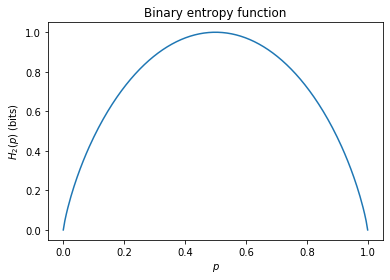

In [5]:
import my_article_support

my_article_support.plot_h2()

### Why scale by $N(\nu)$ ?

What remains to be explained is why we have scaled the Mutual Information by a factor of $N(\nu)$. The reason is that it makes the computed score $G_\nu[S]$ comparable not only across Split Criteria, but also across tree nodes. This makes intuitive sense - you don't care about gaining predictability when very few datapoints are concerned. We'll now provide a more principled demonstration for that.

First, observe that **any Decision Tree $T$ can be viewed as a (sophisticated) way of splitting the data**, partitioning it into as many subsets as it has leaf nodes.

It therefore makes sense to rank Decision Trees by their (global) Mutual Information $I[P,T]$. Tree-growing is now viewed as searching for Decision Trees with a high $I[P,T]$ score.

Now, for our iterative tree-growing algorithm, the question becomes: given a tree $T$, how to expand it into a tree $T'$ in a way that achieves the highest possible $I[P,T']$ score?

Denote $T_{\nu \prec S}$ the tree obtained by expanding $T$ at leaf node $\nu$ with Split Criterion $S$. It is easily verified that:

$$I[P,T_{\nu \prec S}] = I[P,T] + \mathbb{P}(\nu) . I_\nu[P, S]$$

Therefore, the "progress" in Mutual Information that we made by expanding $\nu$ with $S$ is of $\mathbb{P}(\nu) . I_\nu[P, S]$ bits.

Denoting $N^{(\text{all})}$ the size of the global dataset and equating probabilities to empirical frequencies, this can be rewritten to:

$$\mathbb{P}(\nu) . I_\nu[P, S] = \frac{N(\nu)}{N^{(\text{all})}} . I_\nu[P, S] = \frac{1}{N^{(\text{all})}} . G_\nu[S]$$

Since $\frac{1}{N^{(\text{all})}}$ is a positive constant, this justifies $G_\nu[S]$ as a global measure of information gain, with the added benefit of not requiring to carry $N^{(\text{all})}$ in computations.

(By the way, $\mathbb{P}(\nu) . I_\nu[P, S]$ is what is conventionally called "Information Gain" in the literature; that's why I've called $G[S]$ the _Total_ Information Gain to make the distinction more explicit)

### Other purity metrics

Our definition of Information Gain uses binary entropy as an impurity metric. For completeness, I should mention that other impurity metrics are sometimes used for choosing the Split Criterion: the most frequent is [Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), which concretely results in replacing the $H_2$ function with $(p \mapsto 4 p (1 - p))$.

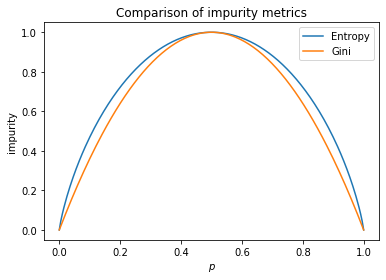

In [2]:
my_article_support.plot_impurity_metrics(0., 1.)

In most cases, I doubt the choice matters much: numerically both functions are similar except in extreme purity regions.

## References

* The Wikipedia Page on [Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning) provides a good overview to Decision Trees.
* See Chapters [2](http://www.inference.org.uk/mackay/itprnn/ps/22.40.pdf) and [8](http://www.inference.org.uk/mackay/itprnn/ps/137.157.pdf) of MacKay's _[Information Theory, Inference, and Learning Algorithms](http://www.inference.org.uk/mackay/itila/)_ for a insightful introduction to entropy and Mutual Information. _(I know. I keep recommending this book over and over again. It's not my fault it's the best resource out there on so many topics.)_
* The Scikit-Learn page on Decision Tree provides some [Tips for practical use](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use) (that said, it bears repeating that Scikit-Learn's implementation is definitely more intended for pattern recognition than data exploration).